# Example 8.4: Estimation of spectra from time series data


This example provides an overview of spectral estimation from time series data. It's worth noting that in this example, we're "cheating" slightly, as we already know the exact spectrum of the process for comparison. In real-world structural dynamics applications, however, we must bridge the gap between the time domain and the frequency domain without prior knowledge of the underlying spectrum.

Consider a time series $x(t)$, representing the response of a structure. This time series could originate from computer simulations or be measured data, typically collected using accelerometers. For our purposes, we assume that the data is generated by a stationary stochastic process, meaning that $x(t)$ is one realization of a process with a spectral density function $S_x(\omega)$.

Our goal is to estimate the spectrum $S_x(\omega)$ from this time series data. We use the term *estimate* because, in practical settings, the exact spectrum is unknowable unless we have an infinitely long time series that contains no measurement noise. We have to accept some uncertainties when we deal with measurement data.

There exist several methods that estimate spectra from time domain data, most of which utilize the Fourier transform. Below, we demonstrate two on the most simple but important methods.





## Method 1: FFT

The first method is the simplest and is based on the discrete Fourier transform $X_k$ of the time series $x(t)$. In python, we can simply find the spectrum as 

$$ S_{x}(f_k) = T \cdot X_k \bar{X}_k = T \cdot |X_k|^2$$

where $\bar{(~)}$ denotes the complex conjugate and $T$ is the length of the time series signal (in seconds). To find $X_k$ of a time series we use the FFT algorithm. To see why it is so simple, consider the following derivation.

The spectrum is the Fourier transform of the auto correlation function:

$$ S_{x}(\omega) = \frac{1}{2\pi} \int_{-\infty}^{\infty} R_{xx}(\tau) e^{-i\omega\tau} \:\text{d}\tau $$

The auto correlation function could be found by averaging over an infinitely long time series:

$$R_{x}(\tau)=E[ x(t) x(t+\tau) ] = \frac{1}{T} \int_{-T/2}^{T/2}  x(t) x(t+\tau) \:\text{d}t, \quad T \rightarrow \infty $$


We inserted this into the spectrum:

$$ S_{x}(\omega) = \frac{1}{2\pi} \frac{1}{T} \int_{-\infty}^{\infty}  \int_{-T/2}^{T/2}  x(t) x(t+\tau)   e^{-i\omega\tau} \:\text{d}t  \:\text{d}\tau $$

Next, we change integration variables $\alpha=t, \beta=t+\tau$, and split the double integral into two single integrals:

$$ S_{x}(\omega) = \frac{1}{2\pi} \frac{1}{T} \int_{-\infty}^{\infty}  \int_{-\infty}^{\infty}  x(\alpha) x(\beta)  e^{i\omega\alpha} e^{-i\omega\beta} \:\text{d}\alpha \:\text{d}\beta
 = \frac{1}{2\pi} 
 \frac{1}{T}
 (2\pi)^2
\underbrace{
\big(
\frac{1}{2\pi} 
\int_{-\infty}^{\infty} x(\alpha)  e^{i\omega\alpha}  \:\text{d}\alpha
\big)
}_{\bar{X}(\omega)}
\underbrace{
\big(
\frac{1}{2\pi} 
\int_{-\infty}^{\infty} x(\beta)  e^{-i\omega\beta}  \:\text{d}\beta
\big)
}_{X(\omega)}
=
 \frac{2\pi}{ T}  X(\omega)\bar{X}(\omega)
$$

Here, $X(\omega)$ is the continuous Fourier transform. However, when we dealing with measured time series we have discrete data (i.e. at time instants $t \in [0,\Delta t,2\Delta t ,3\Delta t,\dots]$). Remember the relation between the continuous and discrete Fourier transforms:

 $$ X(\omega_k) = \frac{T}{2\pi} X_k $$
 
We may insert this into the spectrum:
 
 $$ S_{x}(\omega_k)= \frac{2\pi}{ T}  X(\omega_k)\bar{X}(\omega_k) =
  \frac{2\pi}{ T} \frac{T^2}{(2\pi)^2} X_k \bar{X_k}
  = \frac{T}{2\pi}  X_k \bar{X_k}
  $$
  
Finally, we convert from rad/s to Hz using the formula $S_{x}(f_k)=2 \pi S_{x}(\omega_k)$. We may conclude that the spectrum can be found from

 $$ S_{x}(f_k)  = \lim_{T\rightarrow \infty} \text{E} [ \: T \cdot X_k \bar{X}_k \: ]  $$


NB! Due to different definitions of the DFT or FFT, the normalization of the equation above can be different in other sources. The scaling of the spectrum by a constant value does not change its overall shape. The peaks and dips of the spectrum will still be located at the same frequencies. We do however need to keep the correct scaling to preserve the relation:

$$
\sigma^2
=\int_{-\infty}^{\infty} S(\omega) \: \text{d} \omega
$$

We will now define a spectrum and use it to simulate a time series. Then, the spectrum of the process will be re-estimated.


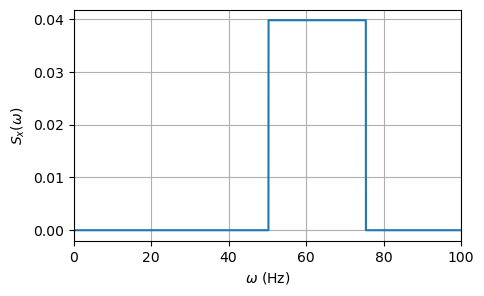

In [14]:
# Simulate time series from a known spectrum

import numpy as np
from matplotlib import pyplot as plt

import numpy as np
from matplotlib import pyplot as plt
from scipy import interpolate
from scipy import signal as spsi

omega1 = 2*np.pi*8 # Low cut-off frequency
omega2 = 2*np.pi*12 # Low cut-off frequency
sigma_x= 1.0 # Standard deviation of the process

domega = 0.01
omega_axis = np.arange(domega,2*np.pi*100,domega) # Frequency axis

Sx = np.ones_like(omega_axis)*sigma_x**2/(omega2-omega1) # Value of the auto-spectral density (one-sided)
Sx[omega_axis<omega1] = 0.00 # Set the auto-spectral density to zero below omega1
Sx[omega_axis>omega2] = 0.00 # Set the auto-spectral density to zero above omega2

plt.figure(figsize=(5,3))
plt.plot(omega_axis,Sx);
plt.ylabel('$S_x(\omega)$');
plt.xlabel('$\omega$ (Hz)');
plt.xlim(0,100)
plt.grid()

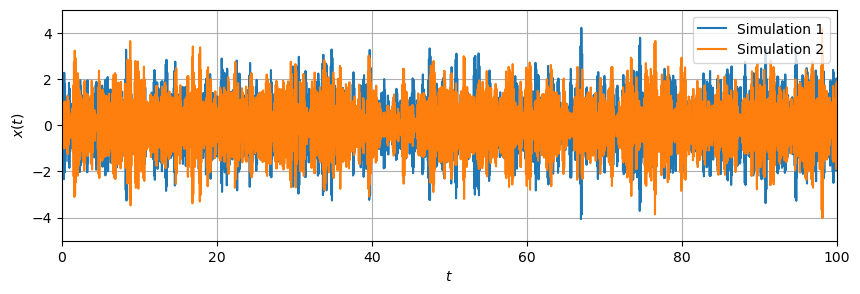

In [15]:
N_sim=100 # Number of simulations
T_sim=100 # Simulation length in seconds

x_all=[None]*N_sim # Empty list to save all simulations

for k in range(N_sim):
    
    phi = np.random.rand(omega_axis.shape[0])*2*np.pi # Random phase angles 

    c = (2*Sx*domega)**0.5*np.exp(1j*phi) # The complex amplitude including the phase angle
    xifft = np.real(np.fft.ifft(c)*omega_axis.shape[0]) # The ifft
    t_sim = np.linspace(0,2*np.pi/domega,omega_axis.shape[0]) # time axis
    
    t=t_sim[t_sim<T_sim] # Time vector, cut to length T_sim
    x_all[k]=xifft[t_sim<T_sim] # Save simulation in list
    
# Plot part of the simulated time series
plt.figure(figsize=(10,3))
plt.plot(t,x_all[0],label = 'Simulation 1')
plt.plot(t,x_all[1],label = 'Simulation 2')
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')
plt.xlim(0,100)
plt.ylim(-5,5)
plt.grid()
plt.legend()

### Spectrum from FFT with one time series

We will now use the FFT method to find the spectrum from the time series. This is called the estimated spectrum or the empirical spectrum. We will start with estimating the spectrum from just *one* time series.

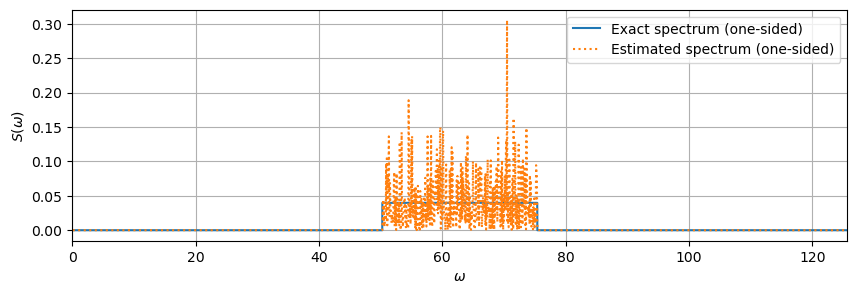

In [16]:
# Estimate spectrum from one time series

dt=t[1]-t[0] # Time step
T=t[-1] # Total measurement period

N = len(t)

Xfft = np.fft.fftshift(np.fft.fft(x_all[0]))/N
f_fft = np.fft.fftshift(np.fft.fftfreq(N, d=dt)) # Frequency axis in Hz

Sx_est_twosided=T*np.real(Xfft*np.conj(Xfft)) # Estimate spectrum (two-sided and function of Hz)

omega_fft=f_fft[f_fft>0]*2*np.pi # One-sided frequency axis in rad/s
Sx_est=Sx_est_twosided[f_fft>0]/(2*np.pi)*2 # One-sided spectrum as function of rad/s

# Plot and compare with exact solution
plt.figure(figsize=(10,3))   
plt.plot(omega_axis,Sx,'-' ,label = 'Exact spectrum (one-sided)') 
plt.plot(omega_fft,Sx_est,':' ,label = 'Estimated spectrum (one-sided)') 
plt.xlabel('$\omega$')
plt.ylabel('$S(\omega)$')
plt.xlim(0,20*2*np.pi)
plt.grid()
plt.legend()

We see that the two spectra generally match, but that the estimated spectrum is very "noisy". This depends on the length of the time series, ideally it should be infinitely long. 

For a complete statistical convergence, we also need multiple realizations of $x(t)$. We then estimate the spectrum for each time series, and finally produce the averaged spectrum. 


### FFT-based spectrum with multiple time series


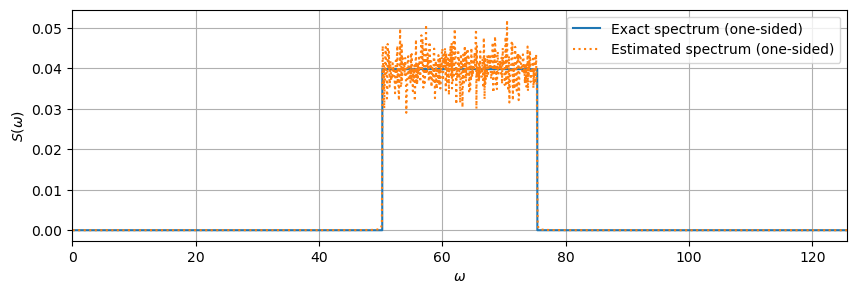

In [17]:
# Estimate spectrum from multiple time series

Sx_est_all=np.zeros((N_sim,Sx_est.shape[0]))

for k in range(N_sim): # Loop over all time series

    Xfft = np.fft.fftshift(np.fft.fft(x_all[k]))/N
    f_fft = np.fft.fftshift(np.fft.fftfreq(N, d=dt)) # Frequency axis in Hz

    Sx_est_twosided=T*np.real(Xfft*np.conj(Xfft)) # Estimate spectrum (two-sided and function of Hz)
        
    omega_fft=f_fft[f_fft>0]*2*np.pi # One-sided frequency axis in rad/s
    Sx_est=Sx_est_twosided[f_fft>0]/(2*np.pi)*2 # One-sided spectrum as function of rad/s
    
    Sx_est_all[k,:]=Sx_est
    
Sx_est_averaged=np.mean(Sx_est_all,axis=0)

# Plot and compare with exact solution
plt.figure(figsize=(10,3))   
plt.plot(omega_axis,Sx,'-' ,label = 'Exact spectrum (one-sided)') 
plt.plot(omega_fft,Sx_est_averaged,':' ,label = 'Estimated spectrum (one-sided)') 
plt.xlabel('$\omega$')
plt.ylabel('$S(\omega)$')
plt.xlim(0,20*2*np.pi)
plt.grid()
plt.legend()

The result is now an estimated spectrum that almost fits the rectangular spectrum. You can try to increase/decrease the variable *N_sim* from 2 to 100 to observe how it converges. You can also try to vary *T_sim* from 10 to 300 s to see its effect on the frequency resolution.

What if we dont have multiple realizations and still want to improve the quality? The next method will produce a much more smooth spectrum from just one time series.

## Method 2: Welch's method

When dealing with measurement data, we do not have multiple time series we can average. As a compromise, we take a single time series and divide it into several segments, as shown in the figure below. This is the idea of Welch's method.

The number of divisions (or equivalently, the length of each segment) is defined by the user. These segments can overlap, with a typical choice being 50% overlap, which is the default setting in most programming environments.

The spectrum is calculated by the FFT method for each segment, and finally the averaged spectrum is the Welch estimate. Since this is an averaging method, the noisy behavior in the previous method will to a large extent be mitigated.

<img src="./figures/Welch.png" width="600px">

The choice of the number of divisions involves a trade-off with advantages and disadvantages:

- **More divisions (=shorter segments)** leads to greater averaging and, therefore, a smoother spectrum. However, the frequency resolution $\Delta f$ or $\Delta \omega$ in the frequency axis becomes bigger. 
- **Less divisions (=longer segments)** leads to less averaging and thus a more noisy spectrum. The advantage is that the frequency resolution is finer.

We may observe these effects if the code example below is changed.

Other useful settings to consider:

- **Windowing**: the time series of each segment is weighted by a so-called Hanning window. The details are not explained here, but this is done to reduce end effects.
- **NFFT**: this parameter zero pads the time series to a given length. For instance, if the time series is 200 points long, setting NFFT=256=2^8 will add 56 zeros at the end. Zero-padding is advantageous because the FFT algorithm performs most efficiently when the length is a power of two.
- **Return one-sided**: this is usually convenient, can it be turned off if a two-sided spectrum is desired.
- **Detrend**: a detrending of the time series is recommended; this means subtracting the mean value so that the signal becomes zero mean. If turned off, the spectrum will have a peak at 0 Hz, which corresponds to a static component of the process. The static component is usually not of interest when looking at a spectrum.


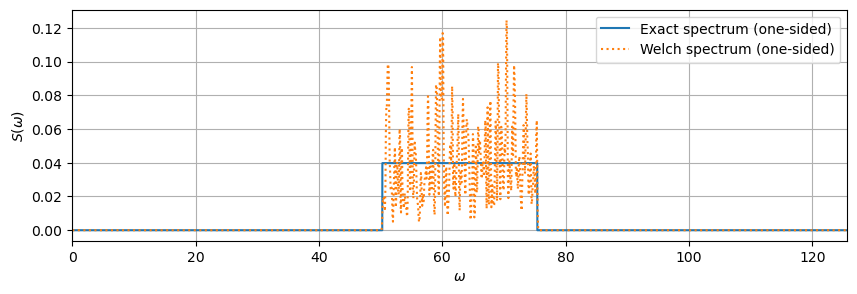

In [21]:
import scipy

Ndivisions=2 # Number of divisions of the time series (total segments)
Nwindow=np.ceil(len(t)/Ndivisions) # Length of window/segment

Nfft_pow2 = 2**(np.ceil(np.log2(Nwindow))) # Next power of 2 for zero padding

# Call welch from scipy signal processing
f_welch, Sx_welch_temp=scipy.signal.welch(x_all[0], fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')

omega_welch=f_welch*2*np.pi # Transform to rad/s
Sx_welch=Sx_welch_temp/(2*np.pi) # Transform to rad/s

# Plot and compare with exact solution
plt.figure(figsize=(10,3))   
plt.plot(omega_axis,Sx,'-' ,label = 'Exact spectrum (one-sided)') 
plt.plot(omega_welch,Sx_welch,':' ,label = 'Welch spectrum (one-sided)')
plt.xlabel('$\omega$')
plt.ylabel('$S(\omega)$')
plt.xlim(0,20*2*np.pi)
plt.grid()
plt.legend()

From the figure above, you see that the Welch spectrum matches quite well. The estimated spectrum is much smoother, but this comes at the cost of a reduced spectral precision (frequency resolution) compared to the FFT method.

## Cross-spectral densities

Until now, we have only considered estimation of auto spectra. Cross-spectrum can be estimated from the FFT in a similar manner:

$$ S_{xy}(f_k) = T \cdot X_{k} \bar{Y}_k $$


When we deal with cross-spectra, or a cross-spectral density matrix, we usually arrange the data as a 3d array shown in the figure below. The two first dimensions represent the DOF dimensions, while the last is the frequency dimension. To obtain the cross-spectral density matrix at one specific frequency, we have to select a "slice" of the 3d array.


<img src="./figures/Spectrum_3d_array.svg" align = "center" style="width:600px" >


The code below shows how to construct the cross spectral density matrix. We call the *csd* function in a double foor loop, this is the same as *welch* except that it takes in two signals $x(t)$ and $y(t)$. If $x=y$, then an auto spectrum is obtained.

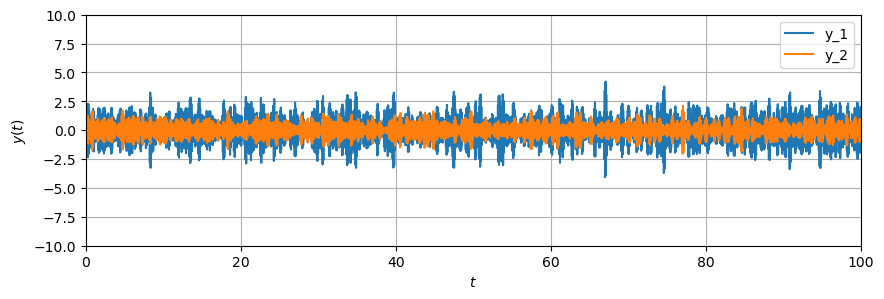

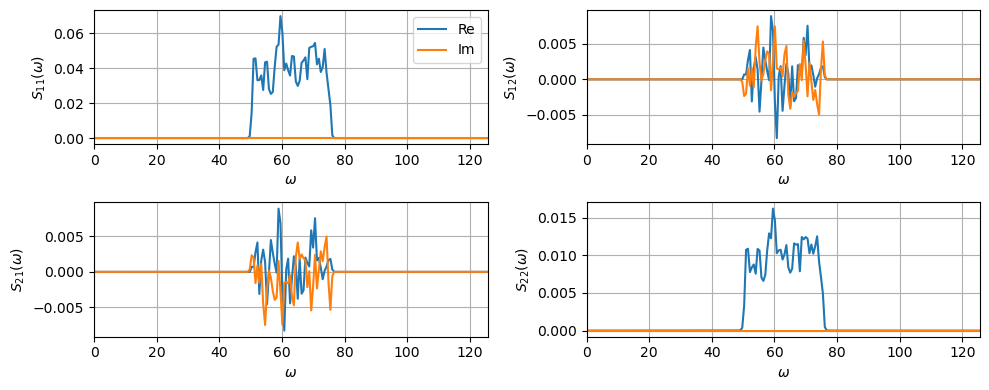

In [19]:
# Welch estimate of cross-spectral density

# Lets create a matrix y with data consisting of two sources:
#i) x; ii) x shifted by 1000 points and mulitiplied by 0.5


y=np.zeros((2,len(t)))

y[0,:]=x_all[0]
y[1,:]=0.5*np.roll(x_all[0],1000)

# Plot part of the simulated time series
plt.figure(figsize=(10,3))
plt.plot(t,y[0,:],label = 'y_1')
plt.plot(t,y[1,:],label = 'y_2')
plt.ylabel(r'$y(t)$')
plt.xlabel(r'$t$')
plt.xlim(0,100)
plt.ylim(-10,10)
plt.grid()
plt.legend()

Ndivisions=10 # Number of divisions of the time series
Nwindow=np.ceil(len(t)/Ndivisions) # Length of window
Nfft_poomega2 = 2**(np.ceil(np.log2(Nwindow))) # Next power of 2

# Spectral matrix
S_welch=np.zeros((2,2,np.int32(Nfft_poomega2/2+1)),dtype=np.complex_)

# Fill spectral matrix by taking the cross spectral density between each of the 3 time series
for k1 in range(2):
    for k2 in range(2):
            f, S_Hz=scipy.signal.csd(y[k1,:],y[k2,:], fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_poomega2, detrend='constant', return_onesided=True, scaling='density', axis=-1, average='mean')
            
            omega_welch=f*2*np.pi # Frequency axis in rad/s
            S_welch[k1,k2,:]=S_Hz/(2*np.pi) # Spectrum in rad/s
            
# Plot spectrum
fig, axs = plt.subplots(2,2,figsize=(10,4))    
for k1 in range(2):
    for k2 in range(2):
        ax = axs[k1,k2]
        ax.plot(omega_welch,np.real(S_welch[k1,k2,:]),label='Re')
        ax.plot(omega_welch,np.imag(S_welch[k1,k2,:]),label='Im')
        ax.set_ylabel(('$S_{' + str(k1+1) + str(k2+1) + '}(\omega)$'))
        ax.set_xlabel('$\omega$')
        ax.grid(True)
        #ax.set_yscale('log')
        ax.set_xlim(0,20*2*np.pi)
        
plt.tight_layout()
axs[0,0].legend()

It can be verified that the auto spectra on the diagonal are purely real, but the cross-spectra have both a real and an imaginary component.